# Прогнозирование оттока клиентов из сети фитнес-центров

## Описание проекта 

**Цель:** Провести анализ анкет и подготовить план действий по удержанию клиентов, разработать рекомендации по повышению качества работы с клиентами.

**Описание данных:** 

Данные клиента за предыдущий до проверки факта оттока месяц:
* `'gender'` — пол;
* `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр;
* `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `'Phone'` — наличие контактного телефона;
* `'Age'` — возраст;
* `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
* `'Contract_period'` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах);
* `'Group_visits'` — факт посещения групповых занятий;
* `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц;
* `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `'Churn'` — факт оттока в текущем месяце.

In [1]:
# Выгрузка необходимых библиотек
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [2]:
# Выгрузка массива данных
path = '/datasets/gym_churn.csv'
df_gym = pd.read_csv(path)

df_gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Подготовка данных

In [3]:
df_gym.columns = df_gym.columns.str.lower()
print('Количество дубликатов:', df_gym.duplicated().sum())
df_gym.info()

Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total      

In [4]:
df_gym['month_to_end_contract'].value_counts()

1.0     2207
6.0      645
12.0     524
11.0     181
5.0      130
10.0      82
9.0       73
4.0       58
8.0       38
7.0       25
3.0       23
2.0       14
Name: month_to_end_contract, dtype: int64

In [5]:
df_gym['month_to_end_contract'] = df_gym['month_to_end_contract'].astype('int')
# df_gym[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']] = \
#             df_gym[['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']].astype('bool')

df_gym = df_gym[['gender',
         'near_location',
         'partner',
         'promo_friends',
         'phone',
         'group_visits',
         'churn',   
         'age',
         'contract_period',
         'month_to_end_contract',
         'lifetime',
         'avg_class_frequency_total',
         'avg_class_frequency_current_month',
         'avg_additional_charges_total']]
df_gym.head()

,gender,near_location,partner,promo_friends,phone,group_visits,churn,age,contract_period,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total
0,1,1,1,1,0,1,0,29,6,5,3,0.020398,0.000000,14.227470
1,0,1,0,0,1,1,0,31,12,12,7,1.922936,1.910244,113.202938
2,0,1,1,0,1,0,0,28,1,1,2,1.859098,1.736502,129.448479
3,0,1,1,1,1,1,0,33,12,12,2,3.205633,3.357215,62.669863
4,1,1,1,1,1,0,0,26,1,1,3,1.113884,1.120078,198.362265


### Вывод

Был предоставлен массив данных из 4000 строк без пропущенных или повторяющихся значений. Произведена замена названий столбцов к единому стилю. 
В колонке `month_to_end_contract` были только целые числа, поэтому можем привели тип данных в ней к целочисленному. 
Так же изменено расположение колонок для удобства, теперь `'gender'` ,`'near_location'`, `'partner'`, `'promo_friends'`, `'phone'`, `'group_visits'`, `'churn'` располагаются рядом.

## Исследовательский анализ данных (EDA)

Посмотрим, есть ли в датасете отсутствующие признаки, изучим средние значения и стандартные отклонения. 

In [6]:
df_gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   group_visits                       4000 non-null   int64  
 6   churn                              4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   contract_period                    4000 non-null   int64  
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [7]:
df_gym.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
churn,4000.0,0.265250,0.441521,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


На первый взгляд, выбросов  и ошибок в данных нет.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [8]:
left = df_gym.query('churn == 1')
stayed = df_gym.query('churn == 0')

print('Средние значения в группе ушедших:\n', left.mean(), sep='')
print('\nСредние значения в группе оставшихся:\n', stayed.mean(), sep='')

Средние значения в группе ушедших:
gender                                 0.510839
near_location                          0.768143
partner                                0.355325
promo_friends                          0.183789
phone                                  0.902922
group_visits                           0.268615
churn                                  1.000000
age                                   26.989632
contract_period                        1.728558
month_to_end_contract                  1.662582
lifetime                               0.990575
avg_class_frequency_total              1.474995
avg_class_frequency_current_month      1.044546
avg_additional_charges_total         115.082899
dtype: float64

Средние значения в группе оставшихся:
gender                                 0.510037
near_location                          0.873086
partner                                0.534195
promo_friends                          0.353522
phone                                  0.903709

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


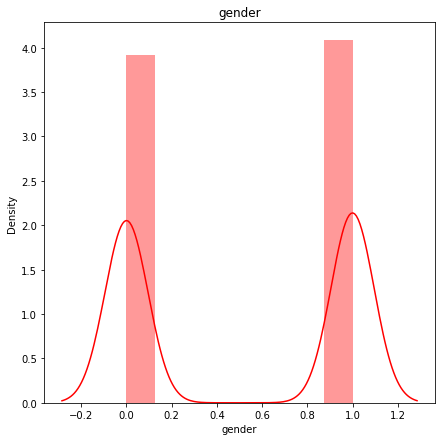

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


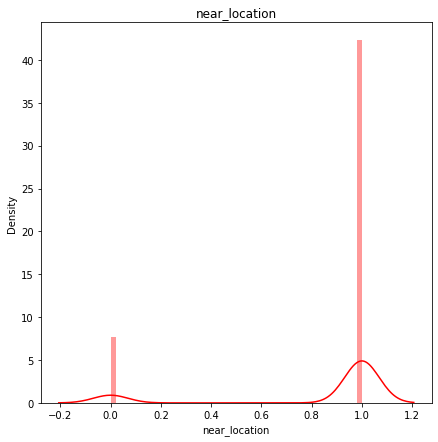

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


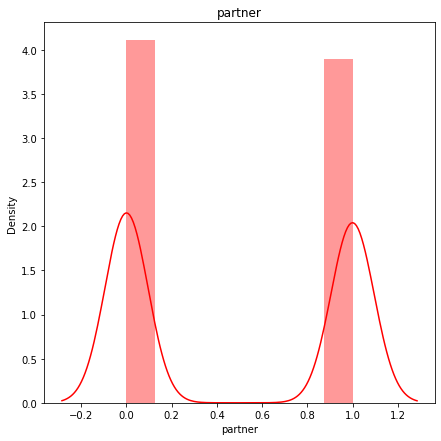

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


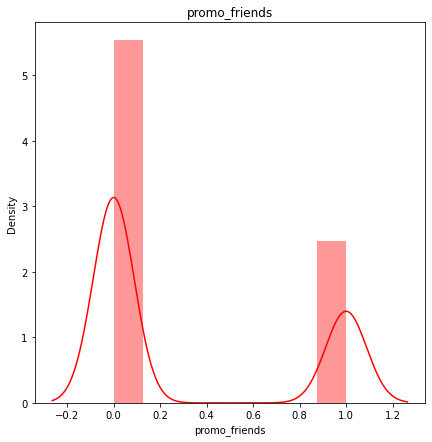

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


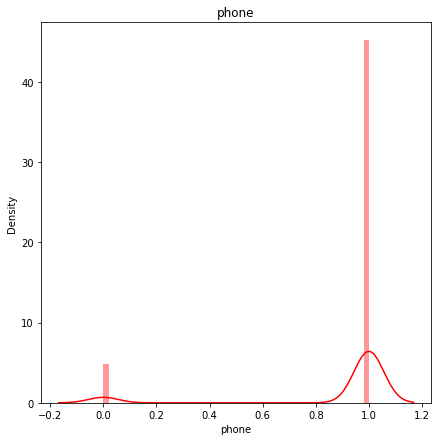

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


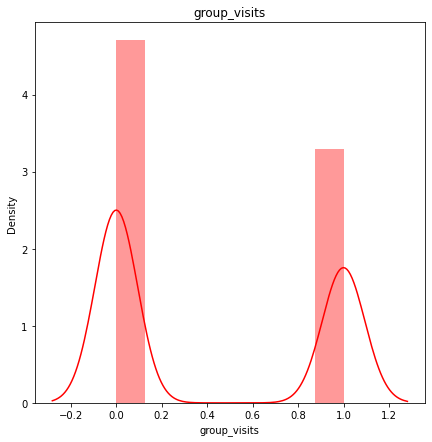

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


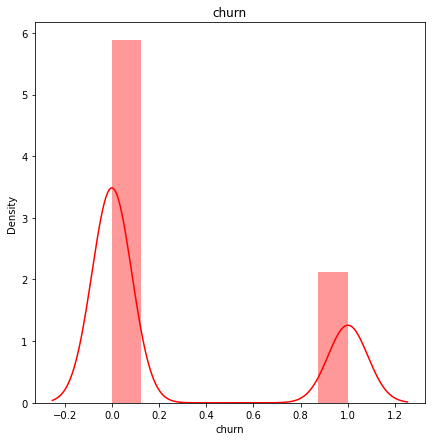

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


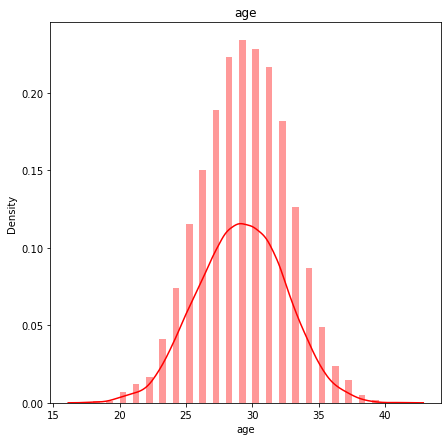

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


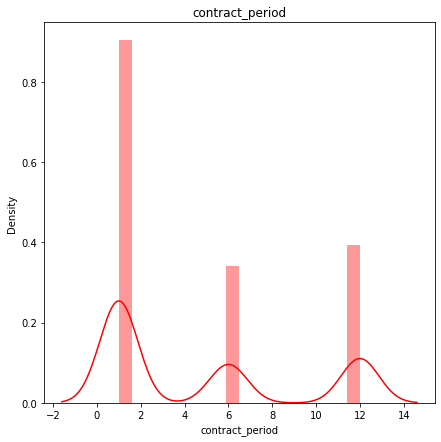

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


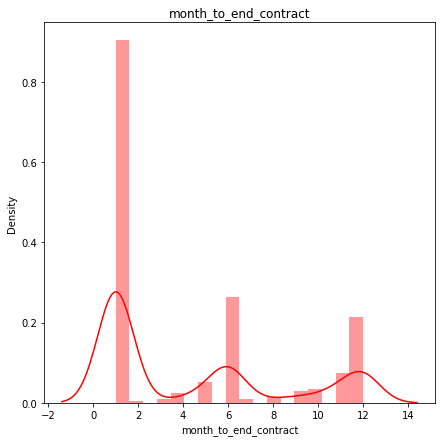

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


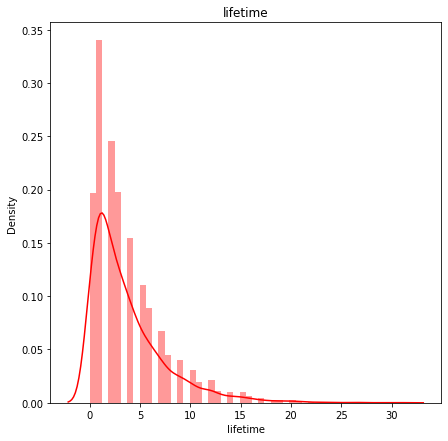

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


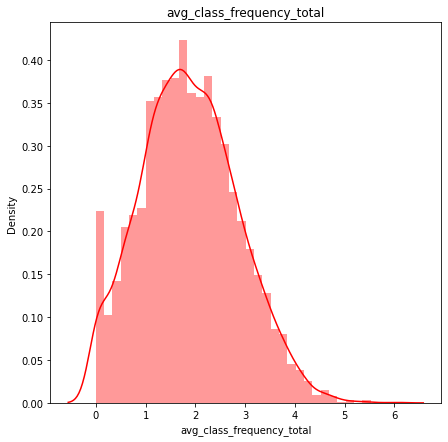

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


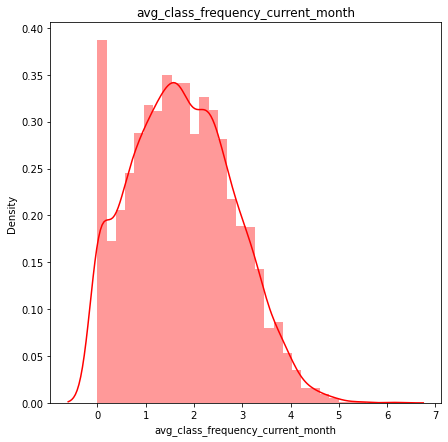

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


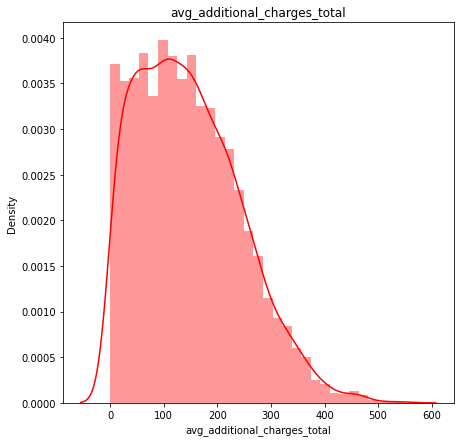

In [9]:
for column in df_gym.columns:
    plt.figure(figsize=(7, 7))
    df_gym.groupby('churn')[column]
    sns.distplot(df_gym[column], color='r')
    plt.title(column)
    plt.show()

 **Вывод:**

* Распределение по полу среди групп ушедших и оставшихся не отличается
* Клиенты из группы оставшихся живут дальше, чем ушедшие
* Сотрудники компаний-партнеров остаются дольше
* Клиенты, пришедшие вместе с друзьями, остаются намного чаще
* Обе группы оставляли свои контакты в среднем одинаково
* Оставшиеся клиенты чаще ходят на групповые занятия
* Средний возраст в группе ушедших - 27 лет, когда как в группе оставшихся - 30 лет
* У группы оставшихся средняя длительность договора - 6 месяцев, когда как в группе оставшихся - почти 2 месяца
* Средняя выручка выше для группы оставшихся

Построим матрицу корреляций и отобразим её.

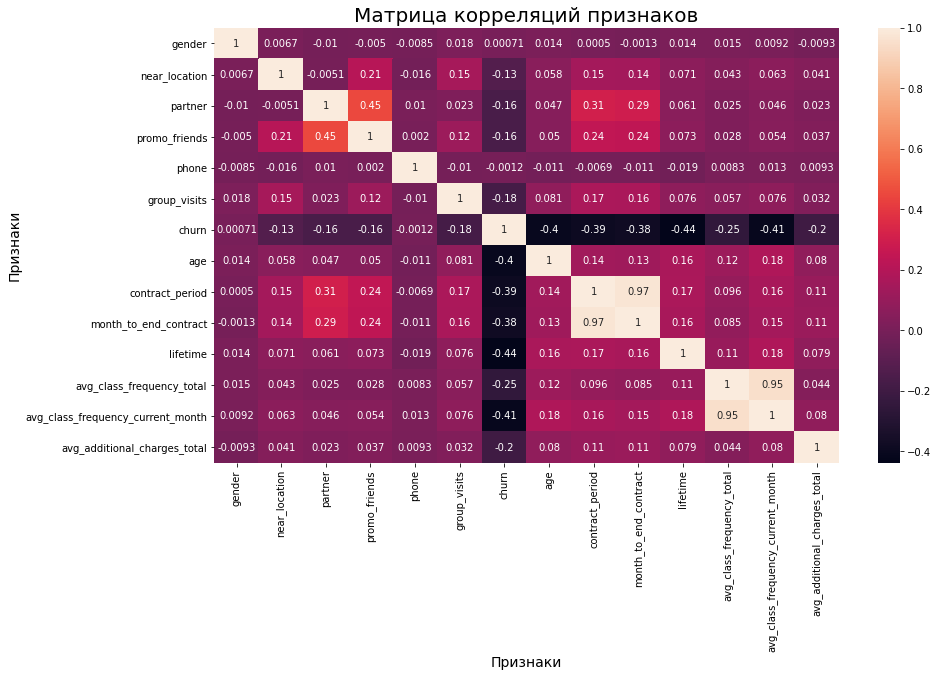

In [10]:
matrix = df_gym.corr()
plt.figure(figsize=(14,8))
sns.heatmap(matrix, annot = True, square=False)
plt.title('Матрица корреляций признаков', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14) 
plt.ylabel('Признаки', fontsize = 14) 
plt.show()

Была выявлена тесная корреляционная взаимосвязь между `month_to_end_contract` и `contract_period`, а также между `avg_class_frequency_total` и `avg_class_frequency_current_month`, однако явных зависимостей между остальными признаками не обнаружено.

### Вывод

Средний возраст клиента 27-30 лет, при этом более молодые клиенты уходят быстрее, тем те, что старше. Так же на потенциальное попадание в отток влияет и то, был ли клиент приглашен другом и является ли он сотрудником. Таким образом, портрет клиента, который с наибольшим шансом уйдет: возраст около 27 лет, был взят абонемент на месяц, не посещает групповые занятия и редко посещает спортзал.

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [11]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_gym.drop('churn', axis = 1)
y = df_gym['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом. Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.

**Логистическая регрессия:**

In [12]:
model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.3f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.3f}'.format(recall_score(y_test, predictions)))
print('F1: {:.3f}'.format(f1_score(y_test, predictions)))

Accuracy: 0.916
Precision: 0.839
Recall: 0.818
F1: 0.829


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Случайный лес:**

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train_st, y_train)

rf_predictions = rf_model.predict(X_test_st) 
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

print('Accuracy: {:.3f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.3f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.3f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.3f}'.format(f1_score(y_test, rf_predictions)))

Accuracy: 0.914
Precision: 0.841
Recall: 0.803
F1: 0.822


### Вывод

Обе модели показали себя хорошо, чуть лучше была модель, основанная на логистической регрессии.

## Кластеризация клиентов

Стандартизируем данные. Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. 

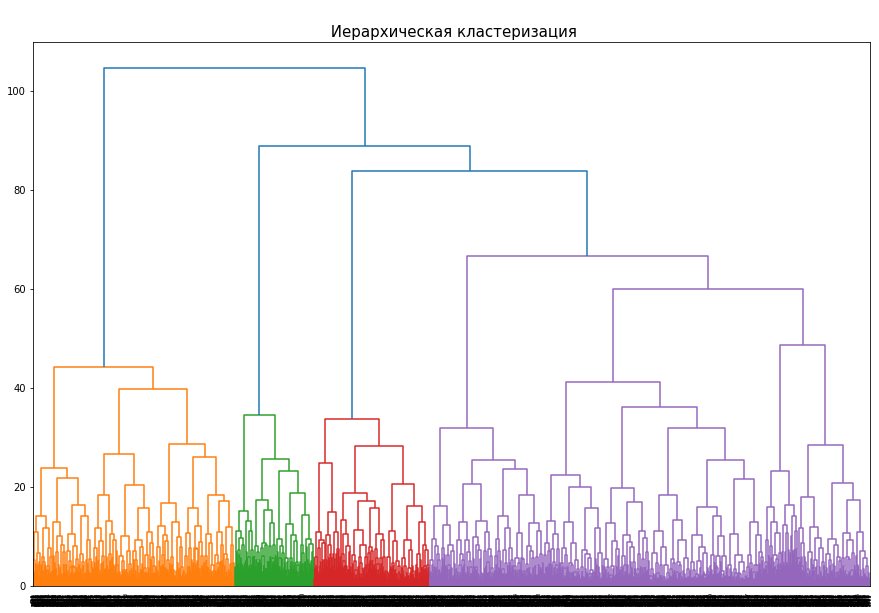

In [14]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('\n Иерархическая кластеризация', fontsize=15)
plt.show()

**На основании алгоритма K-Means:**

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. 

In [15]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X_sc)
df_gym['cluster_km'] = labels

Посмотрим на средние значения признаков для кластеров. 

In [16]:
df_gym.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
churn,0.027723,0.267532,0.443564,0.514263,0.068019
age,29.982178,29.301299,28.477228,28.167987,30.125298
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


* Наиболее низкий отток (2.7%) в 0-м кластере, при этом клиенты из него находятся на близком расстоянии к фитнес-центру и их большая часть является сотрудниками. Самые долгосрочные абонемент также наблюдаются в 0-м кластере и составляют около 11 месяцев.
* Самый большой отток (51.4%) в 3-ем кластере, что логично, ведь меньше половины клиентов из этого кластера пришли вместе с друзьями или являются сотрудниками.

### Распределения признаков

Построим распределения признаков для кластеров.

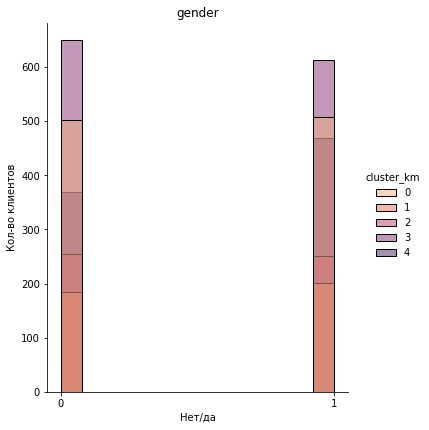

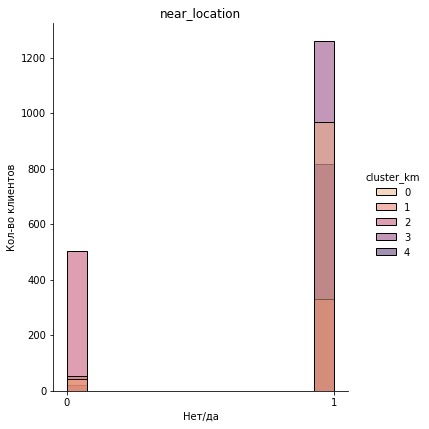

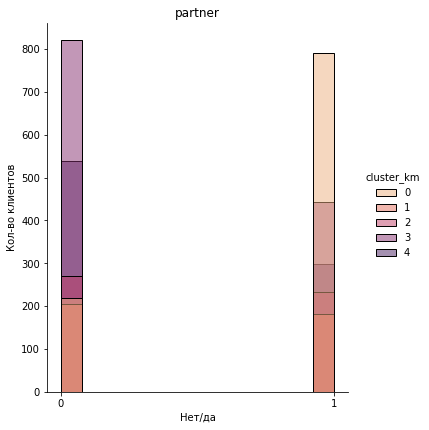

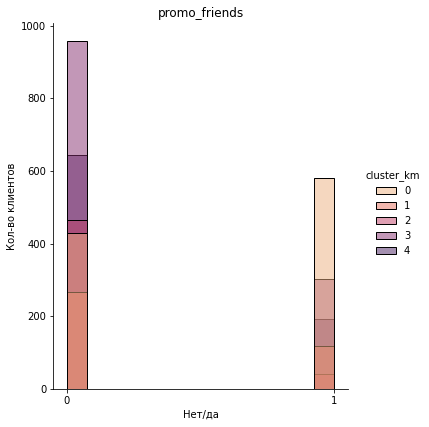

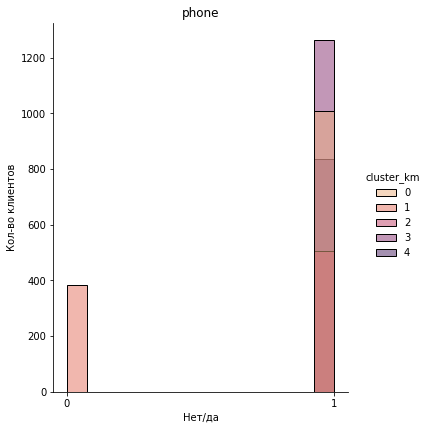

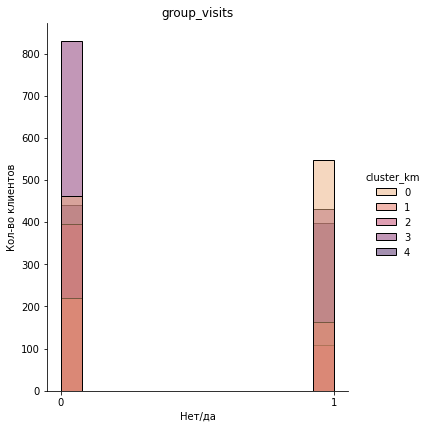

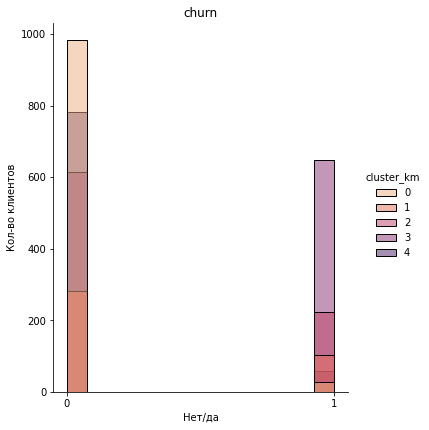

In [17]:
for column in ['gender','near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']:
    g = sns.displot(df_gym, x=df_gym[column], hue='cluster_km', palette='flare')
    plt.xticks([0, 1])
    plt.ylabel("Кол-во клиентов")
    plt.xlabel("Нет/да")
    plt.title(column)
    g.fig.set_figwidth(6)
    g.fig.set_figheight(6)

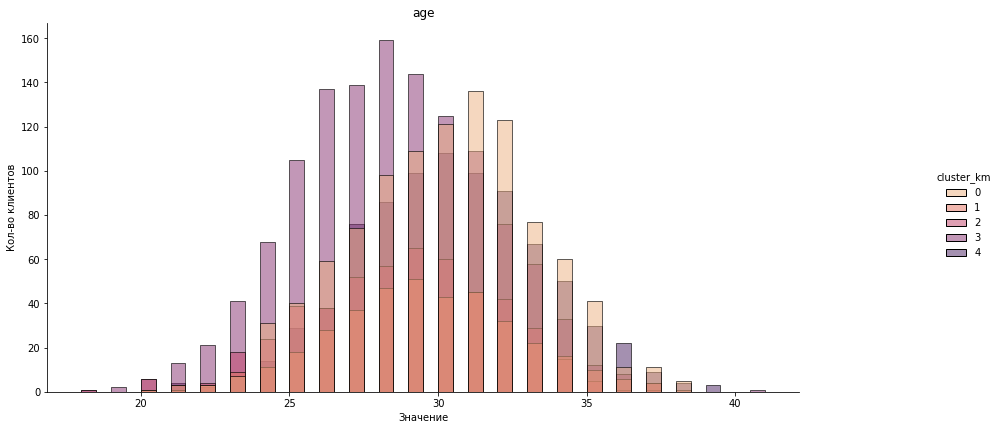

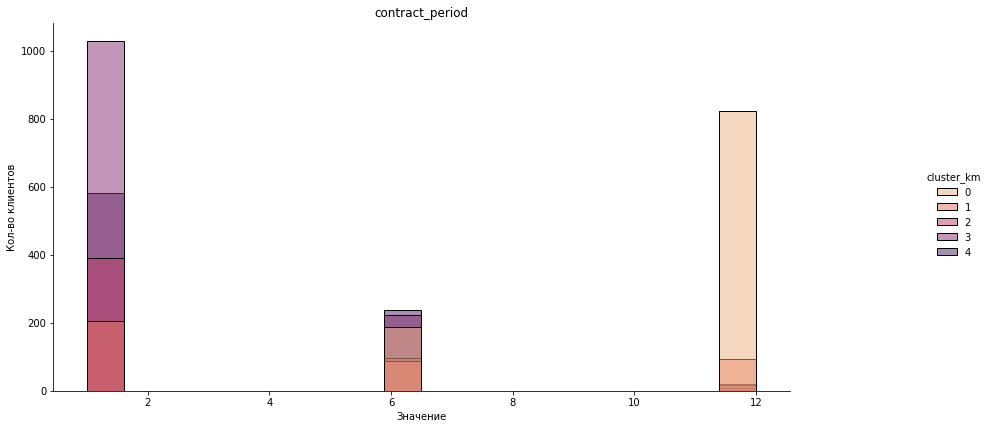

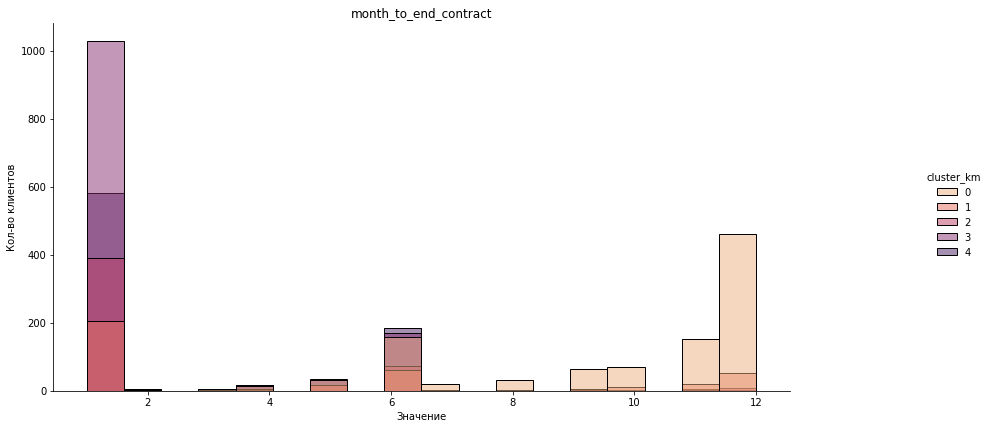

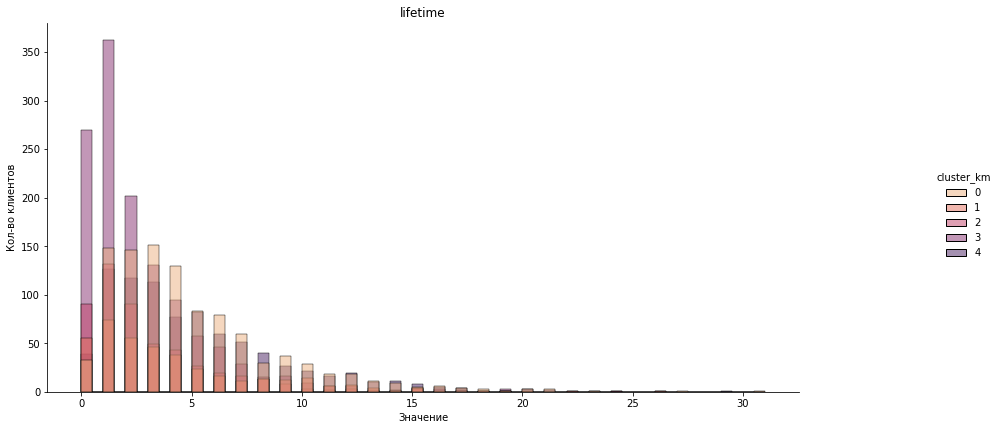

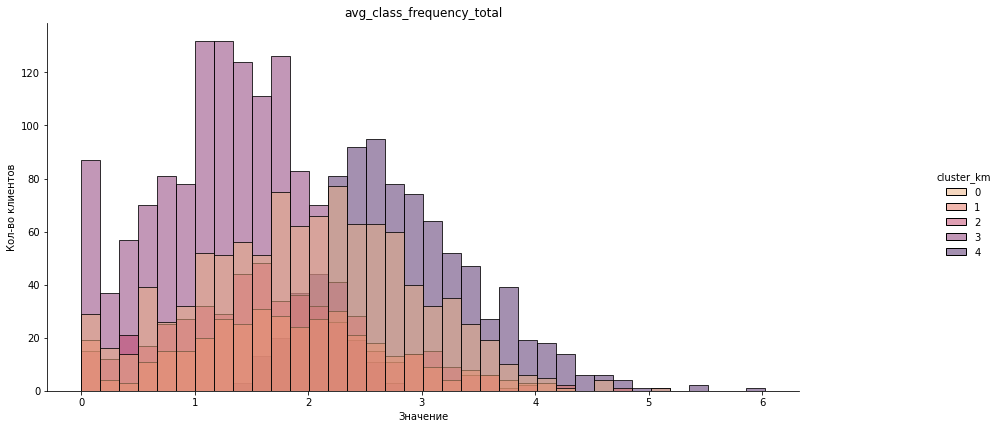

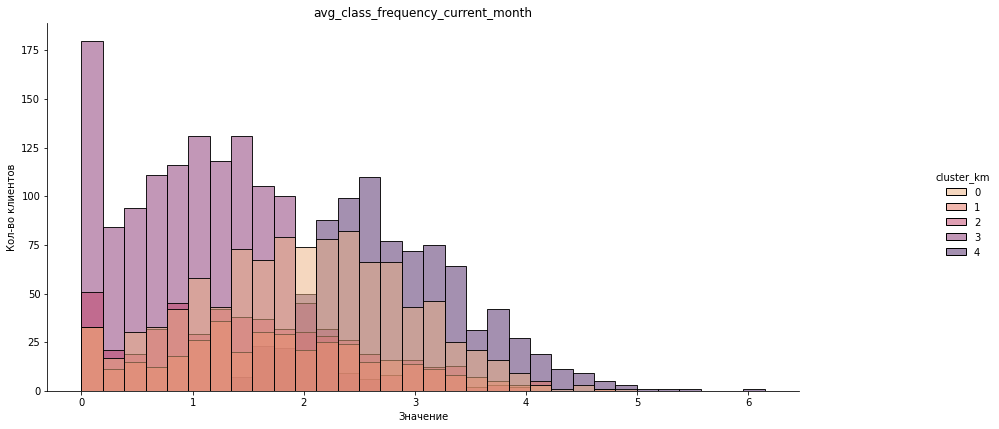

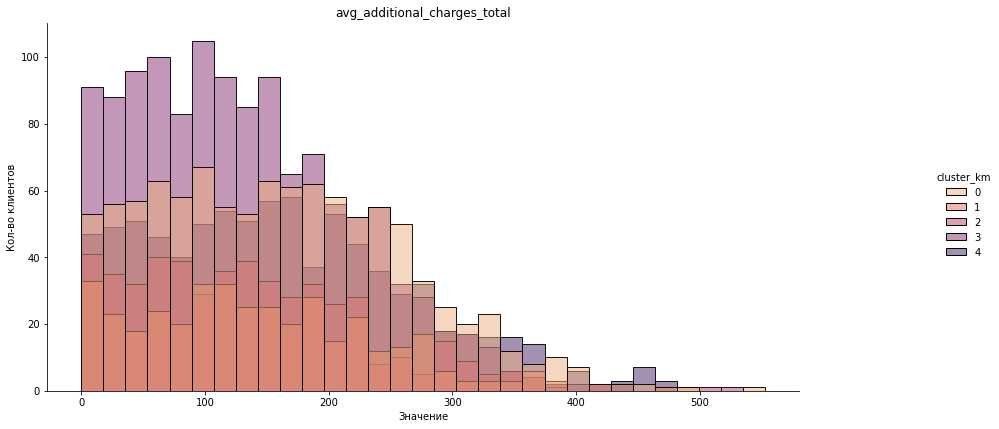

In [18]:
for column in ['age', 'contract_period', 'month_to_end_contract', \
               'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']:
    g = sns.displot(df_gym, x=df_gym[column], hue='cluster_km', kind='hist', palette='flare') 
    plt.title(column)
    plt.ylabel("Кол-во клиентов")
    plt.xlabel('Значение')
    g.fig.set_figwidth(15)
    g.fig.set_figheight(6)

**Вывод:**

* По полу клиенты распределены примерно порову во всех кластерах
* Наименьший отток - в 0-м кластере, наибольший - в 3-м
* Средний возраст клиентов - 29 лет
* По длительности абонемента лидирует кластер 0 - у клиентов из него остается больше 8 месяцев
* В кластер 2 попали клиенты, находящиеся далеко от фитнес-центра
* В 1-м кластере клиенты не оставляли номеров телефона 

### Доли оттока

Для каждого полученного кластера посчитаем долю оттока.

In [19]:
df_gym.groupby('cluster_km').agg({'churn':'mean'}).sort_values(by='churn', ascending=False)

,churn
cluster_km,
3,0.514263
2,0.443564
1,0.267532
4,0.068019
0,0.027723


**Вывод:**

Кластеры отличаются по доле оттока, наибольший отток у 3-го кластера - 51.4%, наименьший - у 0-го (27.7%). Отток для 2-го кластера - 44,3%, для 1-го - 26,7% и для 4-го - 6.8%.
Наиболее надежным по-прежнему выглядит 0-й кластер.

## Общий вывод и рекомендации

В результате исследования было выделено 5 различающихся по признакам кластеров клиентов:
* Самый прибыльный и стабильный кластер - `Кластер 0`. В нем наименьший отток, составляющий `2.8%`, а так же клиенты, купившие абонемент в среднем на 12 месяцев, от которого остается больше 6 месяцев. Эти клиенты стабильно посещают фитнес-центры  около 2-х раз в неделю и отдают преимущество групповым занятиям.
* Следующий по надежности кластер - `Кластер 4`. Здесь доля оттока составляет `6,8%`, что идет вторым по возрастанию
* Не самые лучшие результаты в кластерах `2` и `1`. Отток в них `44,3%` и `26,7%` соответственно, а так же в первом кластере клиенты не оставляли номеров телефона, во втором - далеко находятся от фитнес-центра.
* Самый плохой кластер - `Кластер 3`. В нем наибольшая доля оттока - `51.4%`, клиенты редко посещают зал и мало пользовались абонементом.

**Рекомендации:**

* Уделить больше внимания промо-акциям и программам для сотрудников
* Развивать удобство групповых занятий и предлагать их клиентам
* Увеличивать продажи долгосрочных абонементов
* Для клиентов, живущих далеко, предложить акцию, по которой у них будет больше стимула приезжать в фитнес-центр